### Model tests notebook
Tests in this notebook is all done by Claude AI for better analysis

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

# Disable XLA JIT compilation to avoid GPU issues
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

# Configure GPU memory growth to avoid memory issues
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU setup error: {e}")

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

2025-09-07 17:08:18.500689: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-07 17:08:18.508495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757245098.517902  129132 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757245098.520968  129132 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757245098.528205  129132 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
# Load tokenizer and model directly from HuggingFace
model_name = "im-tsr/distilbert-finetuned-youtube_sentiment_analysis"
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

# Get label mappings directly from the model's config
id2label = model.config.id2label
label2id = model.config.label2id

print("Model loaded successfully!")
print("Label mapping:", id2label)
print("Model summary:")
print(f"Model type: {model.config.model_type}")
print(f"Number of labels: {model.config.num_labels}")

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Model loaded successfully!
Label mapping: {0: 'NEUTRAL', 1: 'POSITIVE', 2: 'NEGATIVE'}
Model summary:
Model type: distilbert
Number of labels: 3


In [12]:
def predict_sentiment(text, show_probabilities=True):
    """
    Predict sentiment for a given text
    
    Args:
        text (str): Input text to analyze
        show_probabilities (bool): Whether to show prediction probabilities
    
    Returns:
        dict: Prediction results including label and confidence scores
    """
    try:
        # Tokenize the input text
        inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=512)
        
        # Make prediction using CPU if GPU fails
        with tf.device('/CPU:0'):
            outputs = model(inputs, training=False)
            logits = outputs.logits
        
        # Convert logits to probabilities
        probabilities = tf.nn.softmax(logits, axis=-1)
        probabilities_np = probabilities.numpy()[0]
        
        # Get predicted class
        predicted_class_id = np.argmax(probabilities_np)
        predicted_label = id2label[predicted_class_id]  # HuggingFace models use integer keys
        confidence = probabilities_np[predicted_class_id]
        
        # Create mapping for probabilities based on label order
        prob_mapping = {}
        for i, label in id2label.items():
            prob_mapping[label] = float(probabilities_np[i])
        
        result = {
            'text': text,
            'predicted_label': predicted_label,
            'confidence': float(confidence),
            'probabilities': prob_mapping
        }
        
        if show_probabilities:
            print(f"Text: '{text}'")
            print(f"Predicted Sentiment: {predicted_label} (Confidence: {confidence:.4f})")
            print("All probabilities:")
            for label, prob in result['probabilities'].items():
                print(f"  {label}: {prob:.4f}")
            print("-" * 50)
        
        return result
        
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        # Return a fallback result
        return {
            'text': text,
            'predicted_label': 'ERROR',
            'confidence': 0.0,
            'probabilities': {
                'NEUTRAL': 0.33,
                'POSITIVE': 0.33,
                'NEGATIVE': 0.34
            },
            'error': str(e)
        }

# Test the function with a simple example
test_text = "This video is amazing! I love it!"
result = predict_sentiment(test_text)
print(f"Test completed successfully: {result['predicted_label'] != 'ERROR'}")

Text: 'This video is amazing! I love it!'
Predicted Sentiment: POSITIVE (Confidence: 0.9961)
All probabilities:
  NEUTRAL: 0.0034
  POSITIVE: 0.9961
  NEGATIVE: 0.0006
--------------------------------------------------
Test completed successfully: True


In [13]:
# Create diverse test examples representing different types of YouTube comments
test_comments = [
    # Positive comments
    "This video is absolutely fantastic! Thank you for sharing this amazing content!",
    "Great tutorial! Very helpful and easy to follow. Keep up the good work! 👍",
    "I love this channel so much! Best content on YouTube!",
    "Perfect explanation! This helped me understand the concept completely.",
    "Amazing video quality and great information. Subscribed!",
    
    # Negative comments
    "This is the worst video I've ever watched. Complete waste of time.",
    "Terrible audio quality and boring content. Disliked!",
    "I don't understand anything. This explanation is confusing and unhelpful.",
    "Clickbait title! The video doesn't deliver what it promises.",
    "Why would anyone watch this garbage? Unsubscribed!",
    
    # Neutral comments
    "The video is okay, nothing special but watchable.",
    "Can you make a video about machine learning next?",
    "What software did you use for this?",
    "First comment! Thanks for the upload.",
    "The content is fine but could be improved with better examples.",
    "How long did it take you to make this video?",
    
    # Mixed/Edge cases
    "Great video but the audio could be better.",
    "I liked the first part but the second half was confusing.",
    "Thanks for the video, though I'm not sure about some points you made.",
    "Good effort but I've seen better explanations elsewhere.",
    
    # Emotional expressions
    "OMG this is so cool! 😍🔥",
    "😢 This made me cry... so beautiful",
    "LOL this is hilarious! 😂😂😂",
    "🤮 This is disgusting",
    "😐 Meh... whatever",
]

print(f"Created {len(test_comments)} test comments for evaluation")
print("Sample comments:")
for i, comment in enumerate(test_comments[:5]):
    print(f"{i+1}. {comment}")
print("...")

Created 25 test comments for evaluation
Sample comments:
1. This video is absolutely fantastic! Thank you for sharing this amazing content!
2. Great tutorial! Very helpful and easy to follow. Keep up the good work! 👍
3. I love this channel so much! Best content on YouTube!
4. Perfect explanation! This helped me understand the concept completely.
5. Amazing video quality and great information. Subscribed!
...


In [14]:
# Test the model on all example comments
print("Testing model on example YouTube comments:")
print("=" * 60)

results = []
for i, comment in enumerate(test_comments):
    print(f"\nComment {i+1}:")
    result = predict_sentiment(comment)
    results.append(result)

# Create a summary of predictions
predictions_df = pd.DataFrame([
    {
        'comment': r['text'],
        'predicted_sentiment': r['predicted_label'],
        'confidence': r['confidence'],
        'neutral_prob': r['probabilities']['NEUTRAL'],
        'positive_prob': r['probabilities']['POSITIVE'],
        'negative_prob': r['probabilities']['NEGATIVE']
    }
    for r in results
])

print("\n" + "="*60)
print("PREDICTION SUMMARY")
print("="*60)
print(f"Total comments analyzed: {len(results)}")
print("\nSentiment distribution:")
sentiment_counts = predictions_df['predicted_sentiment'].value_counts()
for sentiment, count in sentiment_counts.items():
    percentage = (count / len(results)) * 100
    print(f"  {sentiment}: {count} ({percentage:.1f}%)")

print(f"\nAverage confidence: {predictions_df['confidence'].mean():.4f}")
print(f"Minimum confidence: {predictions_df['confidence'].min():.4f}")
print(f"Maximum confidence: {predictions_df['confidence'].max():.4f}")

Testing model on example YouTube comments:

Comment 1:
Text: 'This video is absolutely fantastic! Thank you for sharing this amazing content!'
Predicted Sentiment: POSITIVE (Confidence: 0.9965)
All probabilities:
  NEUTRAL: 0.0031
  POSITIVE: 0.9965
  NEGATIVE: 0.0004
--------------------------------------------------

Comment 2:
Text: 'Great tutorial! Very helpful and easy to follow. Keep up the good work! 👍'
Predicted Sentiment: POSITIVE (Confidence: 0.9984)
All probabilities:
  NEUTRAL: 0.0013
  POSITIVE: 0.9984
  NEGATIVE: 0.0003
--------------------------------------------------

Comment 3:
Text: 'This video is absolutely fantastic! Thank you for sharing this amazing content!'
Predicted Sentiment: POSITIVE (Confidence: 0.9965)
All probabilities:
  NEUTRAL: 0.0031
  POSITIVE: 0.9965
  NEGATIVE: 0.0004
--------------------------------------------------

Comment 2:
Text: 'Great tutorial! Very helpful and easy to follow. Keep up the good work! 👍'
Predicted Sentiment: POSITIVE (Confide

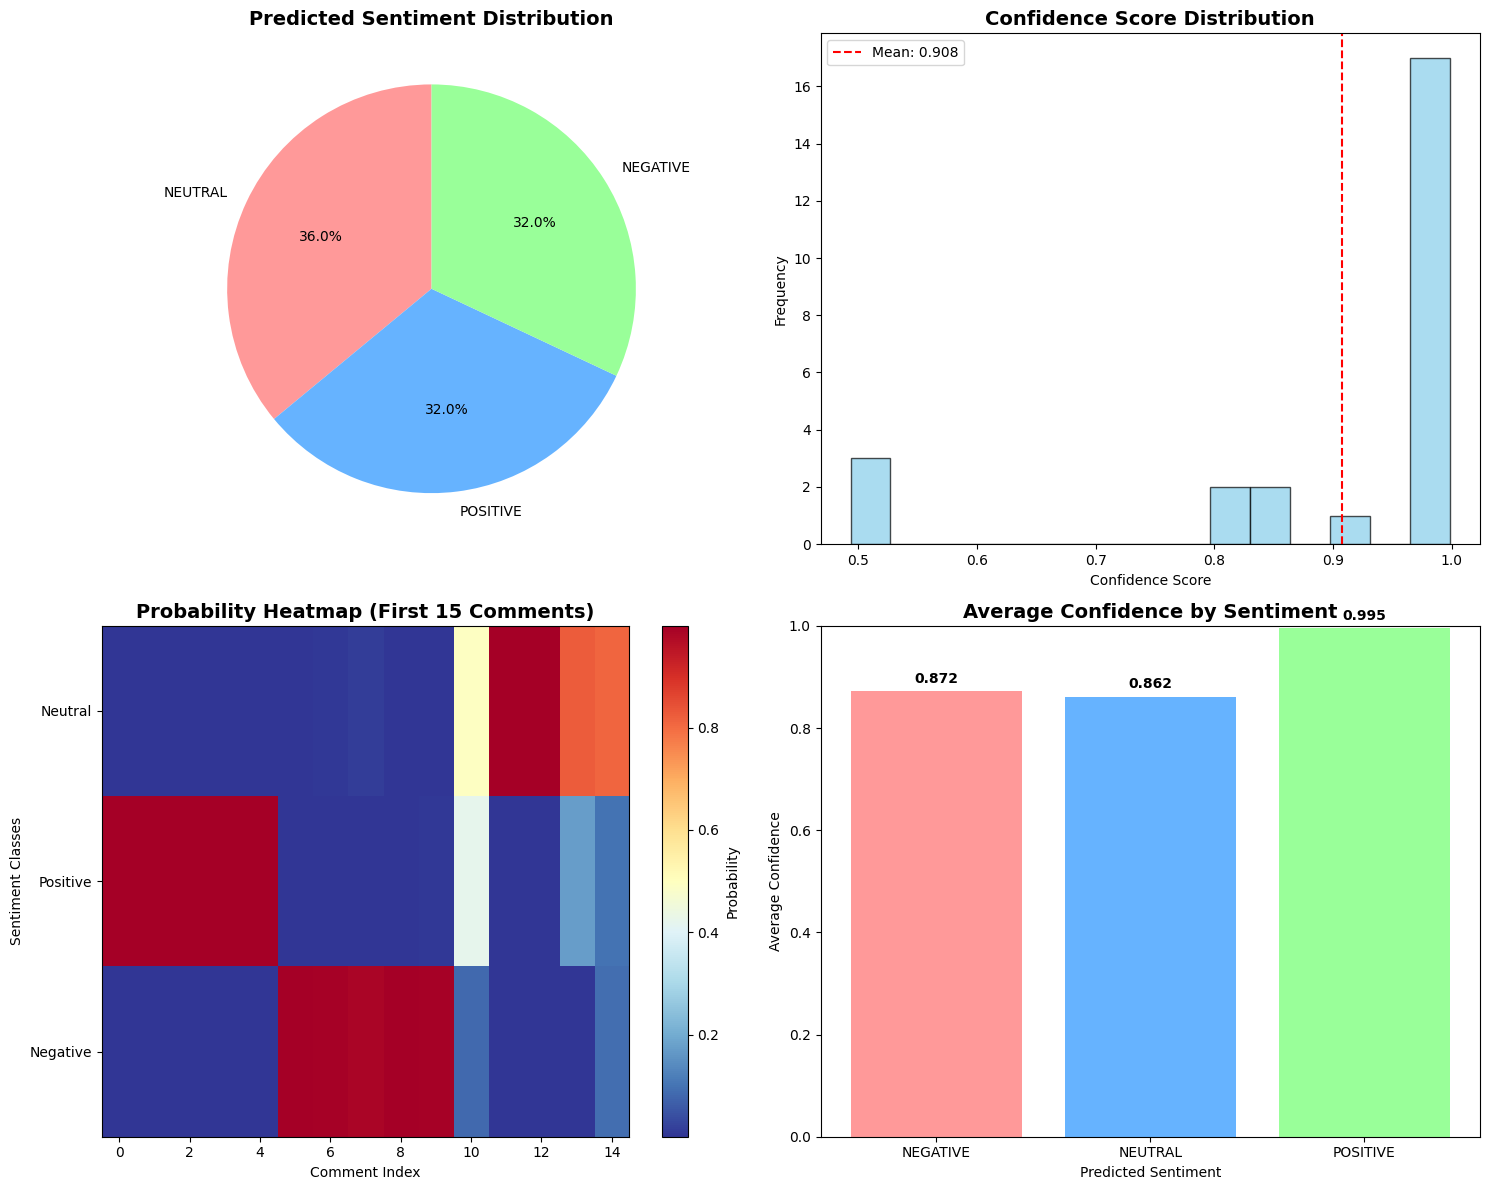

In [15]:
# Visualize the results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Sentiment distribution pie chart
sentiment_counts = predictions_df['predicted_sentiment'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99']
axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
               colors=colors, startangle=90)
axes[0, 0].set_title('Predicted Sentiment Distribution', fontsize=14, fontweight='bold')

# 2. Confidence score distribution
axes[0, 1].hist(predictions_df['confidence'], bins=15, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 1].set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Confidence Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(predictions_df['confidence'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {predictions_df["confidence"].mean():.3f}')
axes[0, 1].legend()

# 3. Probability heatmap for top 15 comments
top_15_probs = predictions_df[['neutral_prob', 'positive_prob', 'negative_prob']].head(15)
im = axes[1, 0].imshow(top_15_probs.T, aspect='auto', cmap='RdYlBu_r')
axes[1, 0].set_title('Probability Heatmap (First 15 Comments)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Comment Index')
axes[1, 0].set_ylabel('Sentiment Classes')
axes[1, 0].set_yticks([0, 1, 2])
axes[1, 0].set_yticklabels(['Neutral', 'Positive', 'Negative'])
plt.colorbar(im, ax=axes[1, 0], label='Probability')

# 4. Confidence by sentiment
sentiment_confidence = predictions_df.groupby('predicted_sentiment')['confidence'].mean()
bars = axes[1, 1].bar(sentiment_confidence.index, sentiment_confidence.values, 
                      color=['#ff9999', '#66b3ff', '#99ff99'])
axes[1, 1].set_title('Average Confidence by Sentiment', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Sentiment')
axes[1, 1].set_ylabel('Average Confidence')
axes[1, 1].set_ylim(0, 1)

# Add value labels on bars
for bar, value in zip(bars, sentiment_confidence.values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [16]:
# Display detailed results table
print("DETAILED RESULTS TABLE")
print("="*80)

# Format the dataframe for better display
display_df = predictions_df.copy()
display_df['comment'] = display_df['comment'].apply(lambda x: x[:50] + '...' if len(x) > 50 else x)
display_df['confidence'] = display_df['confidence'].round(4)
display_df['neutral_prob'] = display_df['neutral_prob'].round(4)
display_df['positive_prob'] = display_df['positive_prob'].round(4)
display_df['negative_prob'] = display_df['negative_prob'].round(4)

# Display results
print(display_df.to_string(index=False))

print("\n" + "="*80)
print("INTERESTING OBSERVATIONS")
print("="*80)

# Find high confidence predictions
high_confidence = predictions_df[predictions_df['confidence'] > 0.9]
print(f"\nHigh confidence predictions (>0.9): {len(high_confidence)}")
for idx, row in high_confidence.iterrows():
    comment_preview = row['comment'][:60] + '...' if len(row['comment']) > 60 else row['comment']
    print(f"  {row['predicted_sentiment']}: '{comment_preview}' (confidence: {row['confidence']:.4f})")

# Find low confidence predictions
low_confidence = predictions_df[predictions_df['confidence'] < 0.6]
print(f"\nLow confidence predictions (<0.6): {len(low_confidence)}")
for idx, row in low_confidence.iterrows():
    comment_preview = row['comment'][:60] + '...' if len(row['comment']) > 60 else row['comment']
    print(f"  {row['predicted_sentiment']}: '{comment_preview}' (confidence: {row['confidence']:.4f})")

DETAILED RESULTS TABLE
                                              comment predicted_sentiment  confidence  neutral_prob  positive_prob  negative_prob
This video is absolutely fantastic! Thank you for ...            POSITIVE      0.9965        0.0031         0.9965         0.0004
Great tutorial! Very helpful and easy to follow. K...            POSITIVE      0.9984        0.0013         0.9984         0.0003
I love this channel so much! Best content on YouTu...            POSITIVE      0.9983        0.0014         0.9983         0.0004
Perfect explanation! This helped me understand the...            POSITIVE      0.9987        0.0009         0.9987         0.0004
Amazing video quality and great information. Subsc...            POSITIVE      0.9961        0.0036         0.9961         0.0003
This is the worst video I've ever watched. Complet...            NEGATIVE      0.9966        0.0014         0.0019         0.9966
Terrible audio quality and boring content. Dislike...            NE

In [17]:
# Interactive testing function
def test_custom_comment(comment):
    """
    Test a custom YouTube comment with detailed analysis
    """
    print("🎯 CUSTOM COMMENT ANALYSIS")
    print("="*50)
    
    result = predict_sentiment(comment, show_probabilities=True)
    
    # Additional analysis
    word_count = len(comment.split())
    char_count = len(comment)
    
    print(f"📊 Text Statistics:")
    print(f"  Word count: {word_count}")
    print(f"  Character count: {char_count}")
    
    # Confidence level interpretation
    confidence = result['confidence']
    if confidence > 0.8:
        confidence_level = "Very High"
        confidence_emoji = "🎯"
    elif confidence > 0.6:
        confidence_level = "High"
        confidence_emoji = "✅"
    elif confidence > 0.4:
        confidence_level = "Medium"
        confidence_emoji = "⚠️"
    else:
        confidence_level = "Low"
        confidence_emoji = "❌"
    
    print(f"\n{confidence_emoji} Confidence Assessment: {confidence_level}")
    
    # Show probability distribution visually
    print(f"\n📈 Probability Distribution:")
    max_bar_length = 30
    for label, prob in result['probabilities'].items():
        bar_length = int(prob * max_bar_length)
        bar = '█' * bar_length + '░' * (max_bar_length - bar_length)
        print(f"  {label:8} |{bar}| {prob:.3f}")
    
    return result

# Example usage
print("Try testing your own comments!")
print("Use: test_custom_comment('Your comment here')")
print("\nExample:")
custom_result = test_custom_comment("This tutorial is pretty good but the audio quality could be much better!")

Try testing your own comments!
Use: test_custom_comment('Your comment here')

Example:
🎯 CUSTOM COMMENT ANALYSIS
Text: 'This tutorial is pretty good but the audio quality could be much better!'
Predicted Sentiment: POSITIVE (Confidence: 0.8551)
All probabilities:
  NEUTRAL: 0.1378
  POSITIVE: 0.8551
  NEGATIVE: 0.0071
--------------------------------------------------
📊 Text Statistics:
  Word count: 13
  Character count: 72

🎯 Confidence Assessment: Very High

📈 Probability Distribution:
  NEUTRAL  |████░░░░░░░░░░░░░░░░░░░░░░░░░░| 0.138
  POSITIVE |█████████████████████████░░░░░| 0.855
  NEGATIVE |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 0.007
Text: 'This tutorial is pretty good but the audio quality could be much better!'
Predicted Sentiment: POSITIVE (Confidence: 0.8551)
All probabilities:
  NEUTRAL: 0.1378
  POSITIVE: 0.8551
  NEGATIVE: 0.0071
--------------------------------------------------
📊 Text Statistics:
  Word count: 13
  Character count: 72

🎯 Confidence Assessment: Very High

📈 P

In [19]:
from datasets import load_dataset

dataset = load_dataset("im-tsr/comments-sentiments")

# Optional: Test on validation data if available
try:
    # Load validation data
    validation_data = dataset['validation'].to_pandas()
    print("📊 VALIDATION DATA ANALYSIS")
    print("="*50)
    print(f"Validation data shape: {validation_data.shape}")
    print(f"Columns: {list(validation_data.columns)}")
    print("\nFirst few rows:")
    print(validation_data.head())
    
    # If the validation data has the expected structure, test on a sample
    if len(validation_data) > 0:
        # Test on first 10 validation samples
        sample_size = min(10, len(validation_data))
        print(f"\n🧪 Testing on {sample_size} validation samples:")
        print("-" * 60)
        
        validation_results = []
        for idx in range(sample_size):
            # Assuming the text column is named 'text' or 'comment'
            text_col = None
            for col in ['text', 'comment', 'content', 'cleaned_comment']:
                if col in validation_data.columns:
                    text_col = col
                    break
            
            if text_col:
                text = validation_data.iloc[idx][text_col]
                print(f"\nSample {idx + 1}:")
                result = predict_sentiment(text)
                validation_results.append(result)
            else:
                print("Could not find text column in validation data")
                break
        
        if validation_results:
            val_df = pd.DataFrame([
                {
                    'predicted_sentiment': r['predicted_label'],
                    'confidence': r['confidence']
                }
                for r in validation_results
            ])
            
            print(f"\nValidation Results Summary:")
            print(f"Average confidence: {val_df['confidence'].mean():.4f}")
            print("Sentiment distribution:")
            print(val_df['predicted_sentiment'].value_counts())
    
except FileNotFoundError:
    print("⚠️  Validation data not found. Skipping validation test.")
    print("   File path: data/validation.parquet")
except Exception as e:
    print(f"⚠️  Error loading validation data: {str(e)}")
    
print("\n✅ Model testing complete!")

📊 VALIDATION DATA ANALYSIS
Validation data shape: (145542, 2)
Columns: ['text', 'label']

First few rows:
                                                text  label
0  This is a great explanation. Very intuative.  ...      0
1  her cadence of speech for the past few months ...      2
2   Jordan exposin it all platant right wing zionist      2
3           Adhaa jeeva love you beta, god bless you      1
4  Животные очень чувствительны и предупреждение ...      0

🧪 Testing on 10 validation samples:
------------------------------------------------------------

Sample 1:
Text: 'This is a great explanation. Very intuative.  
lets say it is not guaranteed that answer will exist, and we have to return -1 in such case. How could we handle this. Please help.'
Predicted Sentiment: NEUTRAL (Confidence: 0.6523)
All probabilities:
  NEUTRAL: 0.6523
  POSITIVE: 0.2791
  NEGATIVE: 0.0686
--------------------------------------------------

Sample 2:
Text: 'her cadence of speech for the past few month